In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

/Users/dayoungcho/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv("/Users/dayoungcho/Desktop/kaggle/porto-seguro-safe-driver-prediction/train.csv")
test = pd.read_csv('/Users/dayoungcho/Desktop/kaggle/porto-seguro-safe-driver-prediction/test.csv')

## EDA & 전처리

In [3]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,...,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,...,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,...,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,...,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,...,4,4,3,8,0,1,0,0,0,0


- 변수명에 변수 종류가 표시되어 있음
- binary/categorical/integer/float value로 이루어진 변수 존재
- 결측치는 -1로 표시됨

In [5]:
print(train.shape)
print(test.shape)   # target 변수 X

(595212, 59)
(892816, 58)


In [6]:
train.drop_duplicates()
train.shape             # 중복 제거해본 결과 개수에 변동 X => 중복되는 데이터 존재 X

(595212, 59)

In [7]:
train.info()    # null값 X

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

### Metadata

- **role**: input, ID, target
- **level**: nominal, interval, ordinal, binary
- **keep**: True or False
- **dtype**: int, float, str

In [8]:
data = []

for f in train.columns:   

    # role(변수 역할) 정의
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'

    # level(변수 종류) 정의
    if ('bin' in f) or (f == 'target'):
        level = 'binary'
    elif ('cat' in f) or (f == 'id'):
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'

    # id 제외하고 keep=True로 설정
    keep = True
    if f == 'id':
        keep = False

    # dtype 변수 생성
    dtype = train[f].dtype

    # 메타데이터를 변수로 저장하는 딕셔너리
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }

    data.append(f_dict) # 메타데이터로 df 만들기 위해 data 리스트에 append

# 메타데이터 df 생성
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [9]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [10]:
# ex) nominal 변수 추출

meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [11]:
# role과 level로 빈도수 카운트
pd.DataFrame({'count': meta.groupby(['role', 'level'])['role'].size()}).reset_index()
# .size()는 count()와 비슷하지만 size는 NaN까지 포함

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


### Descriptive statistics

변수 타입별로 진행

#### Interval variables

In [12]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


- reg
  - ps_reg_03 변수에 결측치
  - 변수간 range에 차이가 있음 => scaling 적용 고려
<br>
- car
  - ps_car_12, ps_car_15 변수에 결측치
  - 변수간 range에 차이가 있음 => scaling 적용 고려
<br>
- calc
  - 결측치 X
  - max값이 0.9인 것을 보아 ratio 변수인듯
  - 세 변수의 range가 유사

#### Ordinal variables

In [13]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- ps_car_11 변수만 결측치 존재
- 변수들 사이 range에 차이 있음 => scaling 고려

#### Binary variables

In [14]:
v = meta[(meta.level == 'binary') & (meta.keep)].index 
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- target 변수의 평균이 0.036 -> imbalanced
- 다른 변수들의 경우에도 평균이 0에 가까움 -> 대부분의 데이터의 인덱스가 0

### Handling imbalanced classes

target 0을 undersampling  
target 1을 oversampling하는 방법 등도 존재..

In [15]:
desired_apriori = 0.10

# 각 타깃별로 인덱스 추출
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# 각 타깃별 데이터 개수 추출
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

undersampling_rate = ( (1 - desired_apriori) * nb_1) / (nb_0 * desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)  # undersampling 이후 target=0의 개수
print('Rate to undersampling records with target = 0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

undersampled_idx = shuffle(idx_0, random_state = 37, n_samples = undersampled_nb_0) # undersampling할 개체의 인덱스 선정

idx_list = list(undersampled_idx) + list(idx_1) # undersampling 이후의 전체 인덱스

train = train.loc[idx_list].reset_index(drop = True)

Rate to undersampling records with target = 0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


### Data Quality Checks

#### checking missing values

In [16]:
# 결측치 찾기

vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0] # 결측치 비율

        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))

print('\nIn total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values

In total, there are 12 variables with missing values


- ps_car_03_cat과 ps_car_05_cat는 결측치가 과도하게 많음 -> 변수 삭제
- categorical 변수들은 결측치 그대로 남겨둠
- ps_reg_03(continuous): 결측치 18% / 평균으로 대체
- ps_car_11(ordinal): 결측치 3개 / 최빈값으로 대체
- ps_car_12(continuous): 결측치 1개 / 평균으로 대체
- ps_car_14(continuous): 결측치 18% / 평균으로 대체

In [17]:
# 결측치가 많은 변수들을 삭제
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat'] 
train.drop(vars_to_drop, inplace = True, axis = 1)
meta.loc[(vars_to_drop), 'keep'] = False  # 메타데이터에서 삭제한 변수 keep=False로 수정

# 평균값/최빈값으로 대체(Impute)
mean_imp = SimpleImputer(missing_values= -1, strategy = 'mean')
mode_imp = SimpleImputer(missing_values= -1, strategy = 'most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']])
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']])
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']])
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']])

#### checking the cardinality of the categorical variables

- cardinality: number of different values in a variable
    - 중복도가 높다 -> cardinality가 낮다  
    - 중복도가 낮다 -> cardinality가 높다

In [18]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
      dist_values = train[f].value_counts().shape[0] # 카테고리 개수 추출
      print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


ps_car_11_cat 변수만 많은 카테고리 존재  
-> target encoding 적용  
<br>
- Target Encoding: 해당 category에 나타난 target variable의 평균을 이용해 categorical value를 대체하는 방식  
(오버피팅 방지를 위해 각 값에 노이즈(uncertainty)를 추가해줌)

In [19]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series = None,
                  tst_series = None, 
                  target = None, 
                  min_samples_leaf = 1, 
                  smoothing = 1,
                  noise_level = 0):
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis = 1)
    averages = temp.groupby(by = trn_series.name)[target.name].agg(['mean', 'count'])  # target mean 계산
    smoothing = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))  # smoothing 계산
    prior = target.mean()
    averages[target.name] = prior * (1 - smoothing) + averages['mean'] * smoothing
    averages.drop(['mean', 'count'], axis = 1, inplace = True)

    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns = {'index': target.name, target.name: 'average'}),
        on = trn_series.name,
        how = 'left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_trn_series.index = trn_series.index

    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns = {'index': target.name, target.name: 'average'}),
        on = tst_series.name,
        how = 'left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_tst_series.index = tst_series.index 

    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)
    
    

In [20]:
train_encoded, test_encoded = target_encode(train['ps_car_11_cat'],
                                            test['ps_car_11_cat'],
                                            target = train.target,
                                            min_samples_leaf = 100,
                                            smoothing = 10,
                                            noise_level = 0.01)
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis = 1, inplace = True)
meta.loc['ps_car_11_cat', 'keep'] = False
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis = 1, inplace = True)

In [32]:
train

,id,target,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,353762,0,1,1,0,1,0,0,0,0,...,4.0,1.800000,0.600000,0.000000,0.81,0.27,0.00,0.09,0.00,0.00
1,845629,0,1,1,1,1,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.04,0.00,0.12,0.00,0.00,0.36
2,1449185,0,1,1,0,1,0,0,0,0,...,11.0,0.994987,2.984962,0.331662,0.09,0.27,0.03,0.81,0.09,0.01
3,834066,0,1,0,0,1,0,0,0,0,...,13.0,2.884441,1.442221,0.360555,0.64,0.32,0.08,0.16,0.04,0.01
4,436189,0,1,0,0,0,0,1,0,0,...,13.0,2.163331,1.802776,3.244996,0.36,0.30,0.54,0.25,0.45,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216935,1487473,1,1,0,3,0,0,1,0,0,...,10.0,1.581139,0.316228,1.581139,0.25,0.05,0.25,0.01,0.05,0.25
216936,1487566,1,1,0,0,0,0,1,0,0,...,4.0,0.600000,0.800000,1.200000,0.09,0.12,0.18,0.16,0.24,0.36
216937,1487716,1,1,1,0,0,1,0,0,0,...,12.0,1.732051,1.385641,2.078461,0.25,0.20,0.30,0.16,0.24,0.36
216938,1487748,1,2,0,0,1,0,0,0,0,...,14.0,1.870829,0.748331,2.244994,0.25,0.10,0.30,0.04,0.12,0.36


### Visualization

#### categorical variables

- 결측치(카테고리 = -1)인 값들을 대체하지 않는 편이 좋겠다는 결론
  - 사유: The customers with a missing value appear to have a much higher (in some cases much lower) probability to ask for an insurance claim.

<Figure size 640x480 with 0 Axes>

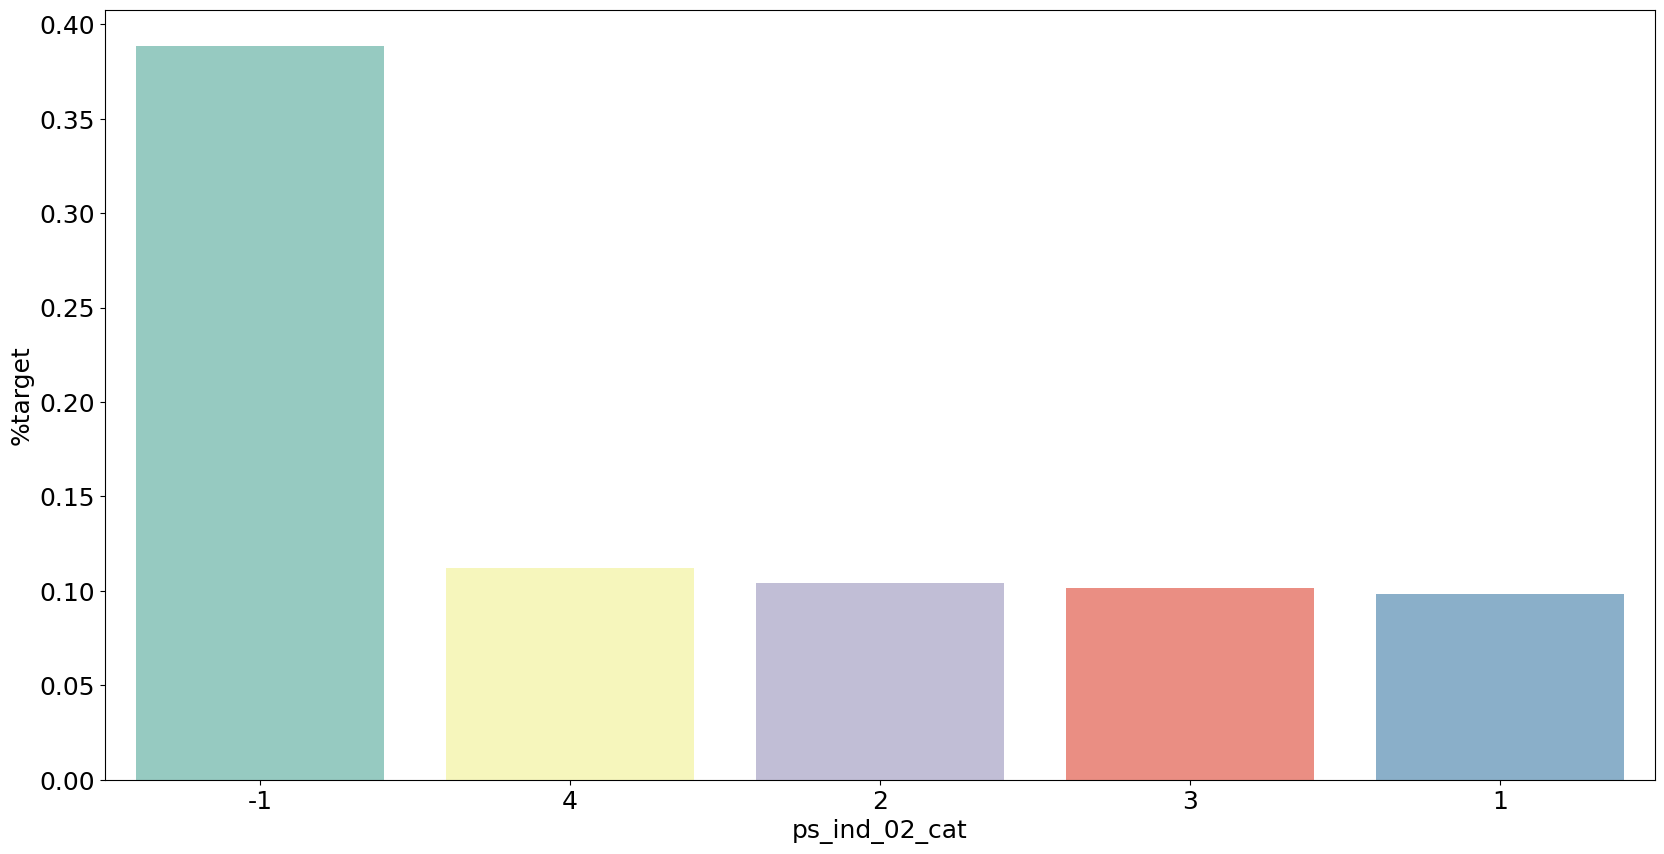

<Figure size 640x480 with 0 Axes>

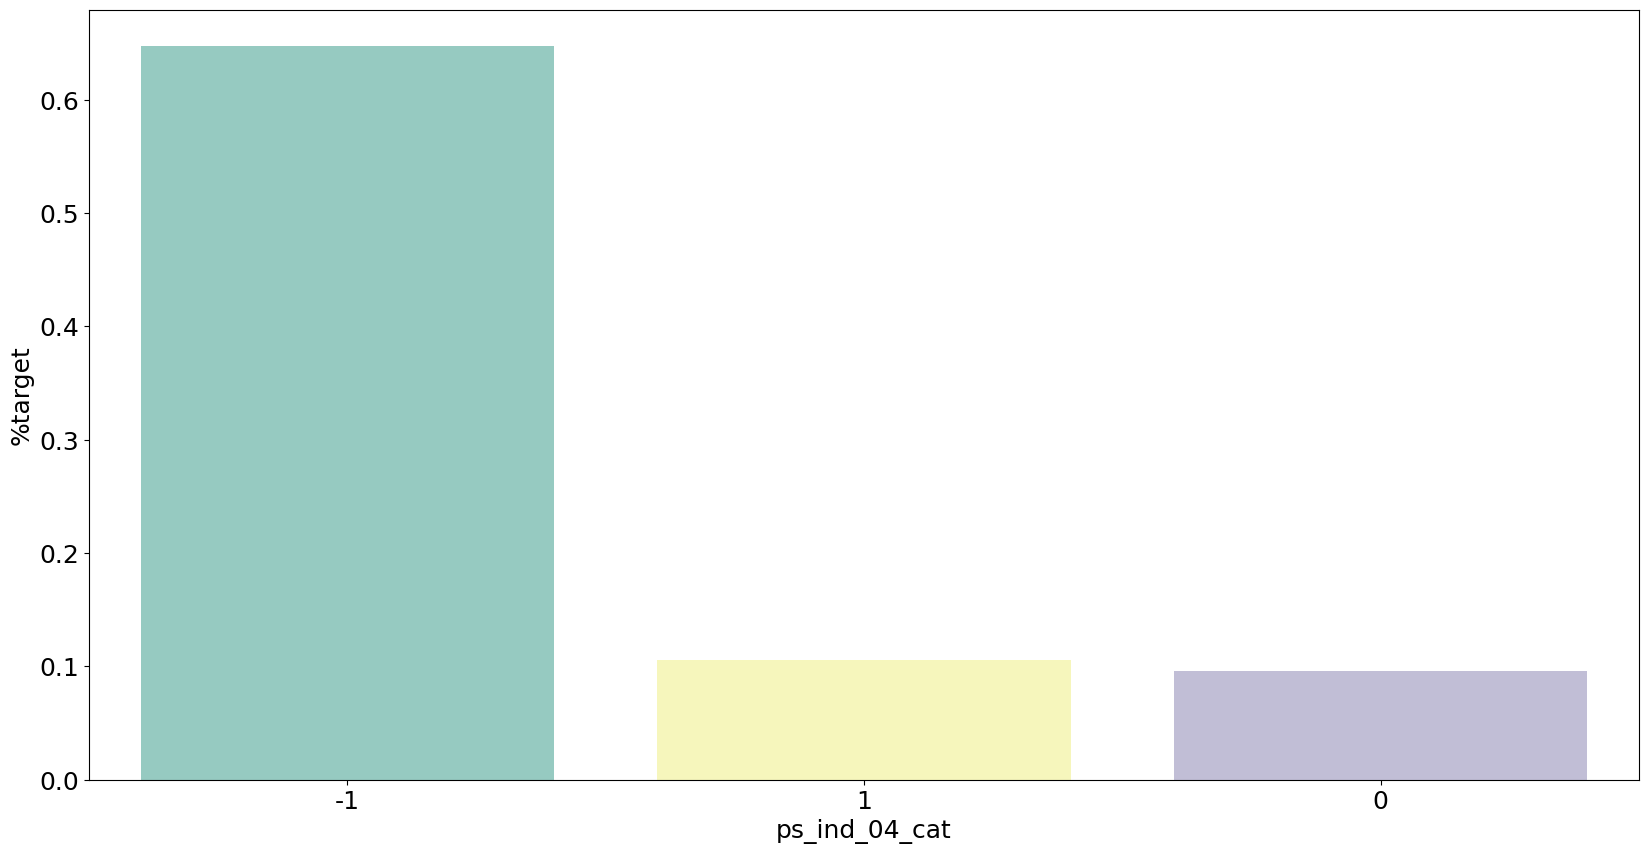

<Figure size 640x480 with 0 Axes>

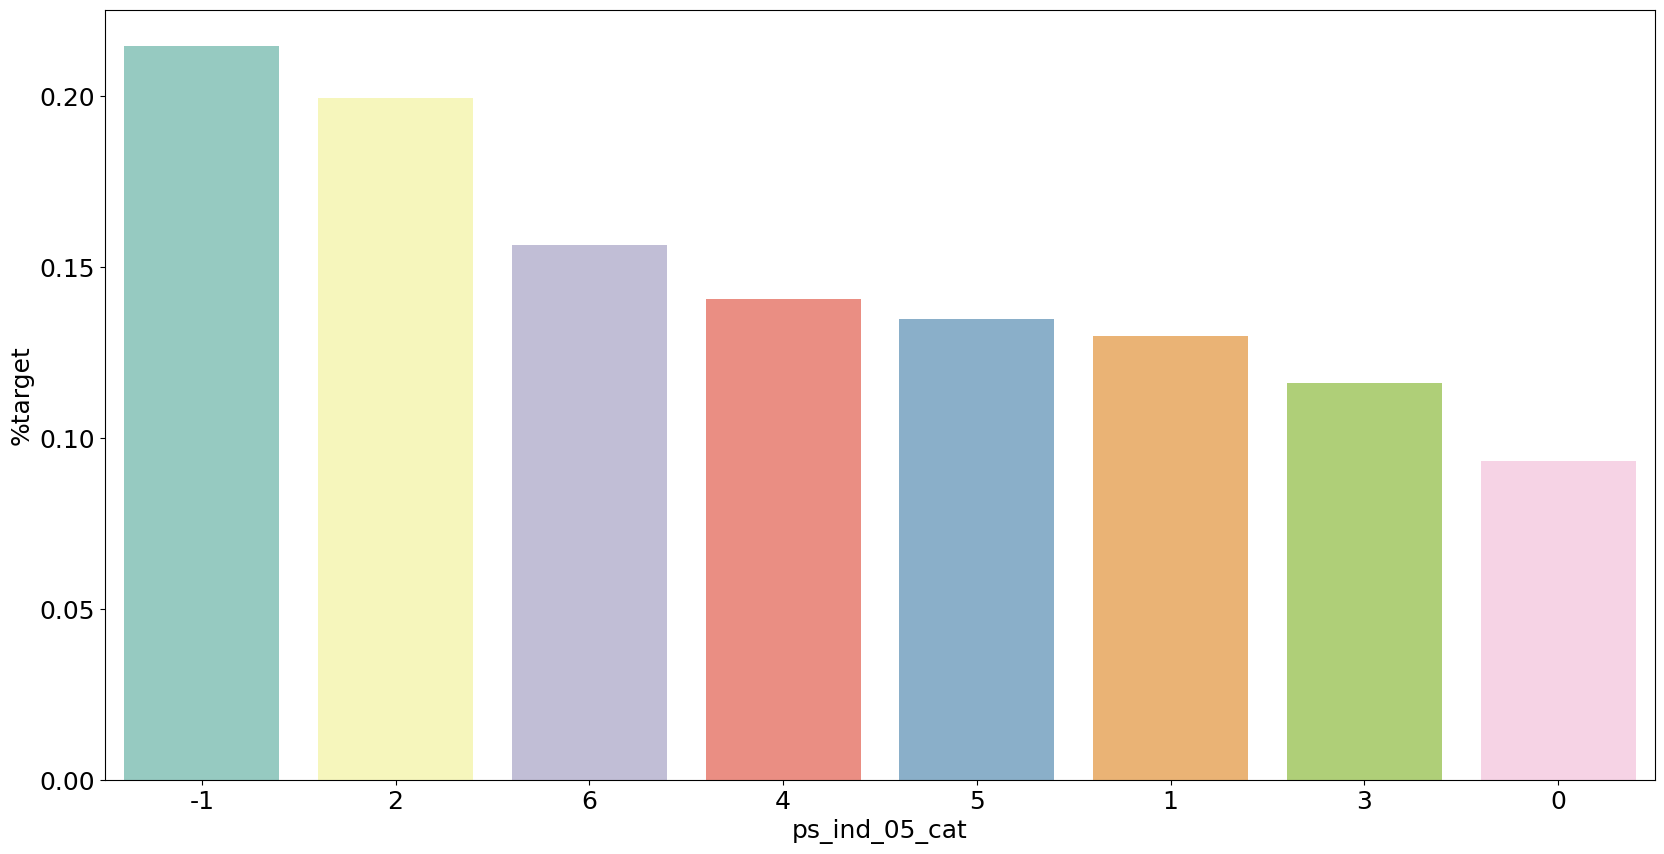

<Figure size 640x480 with 0 Axes>

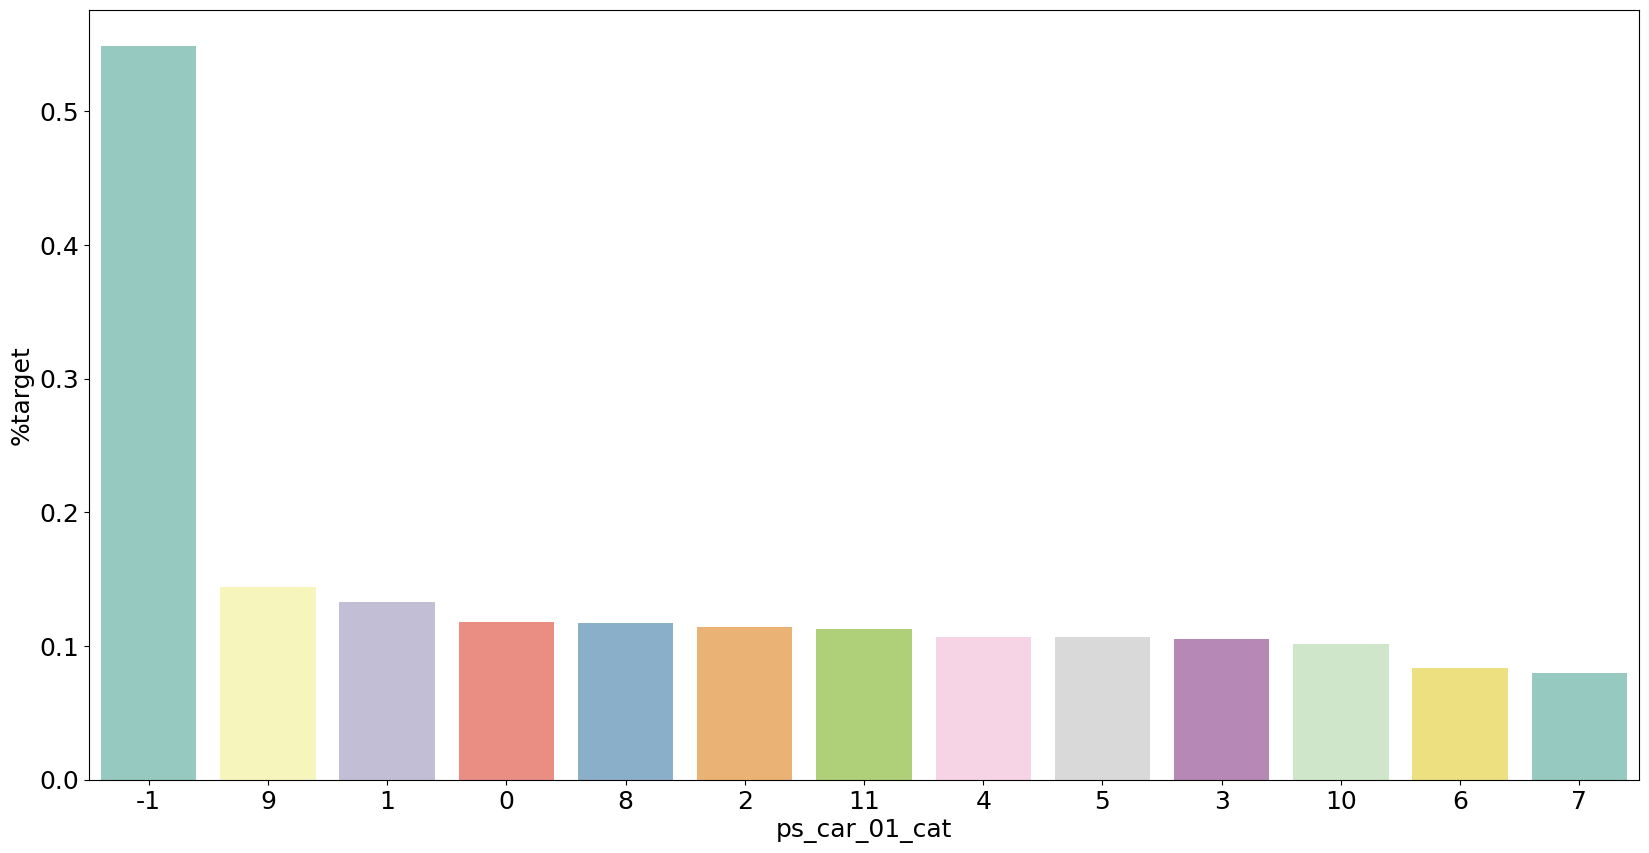

<Figure size 640x480 with 0 Axes>

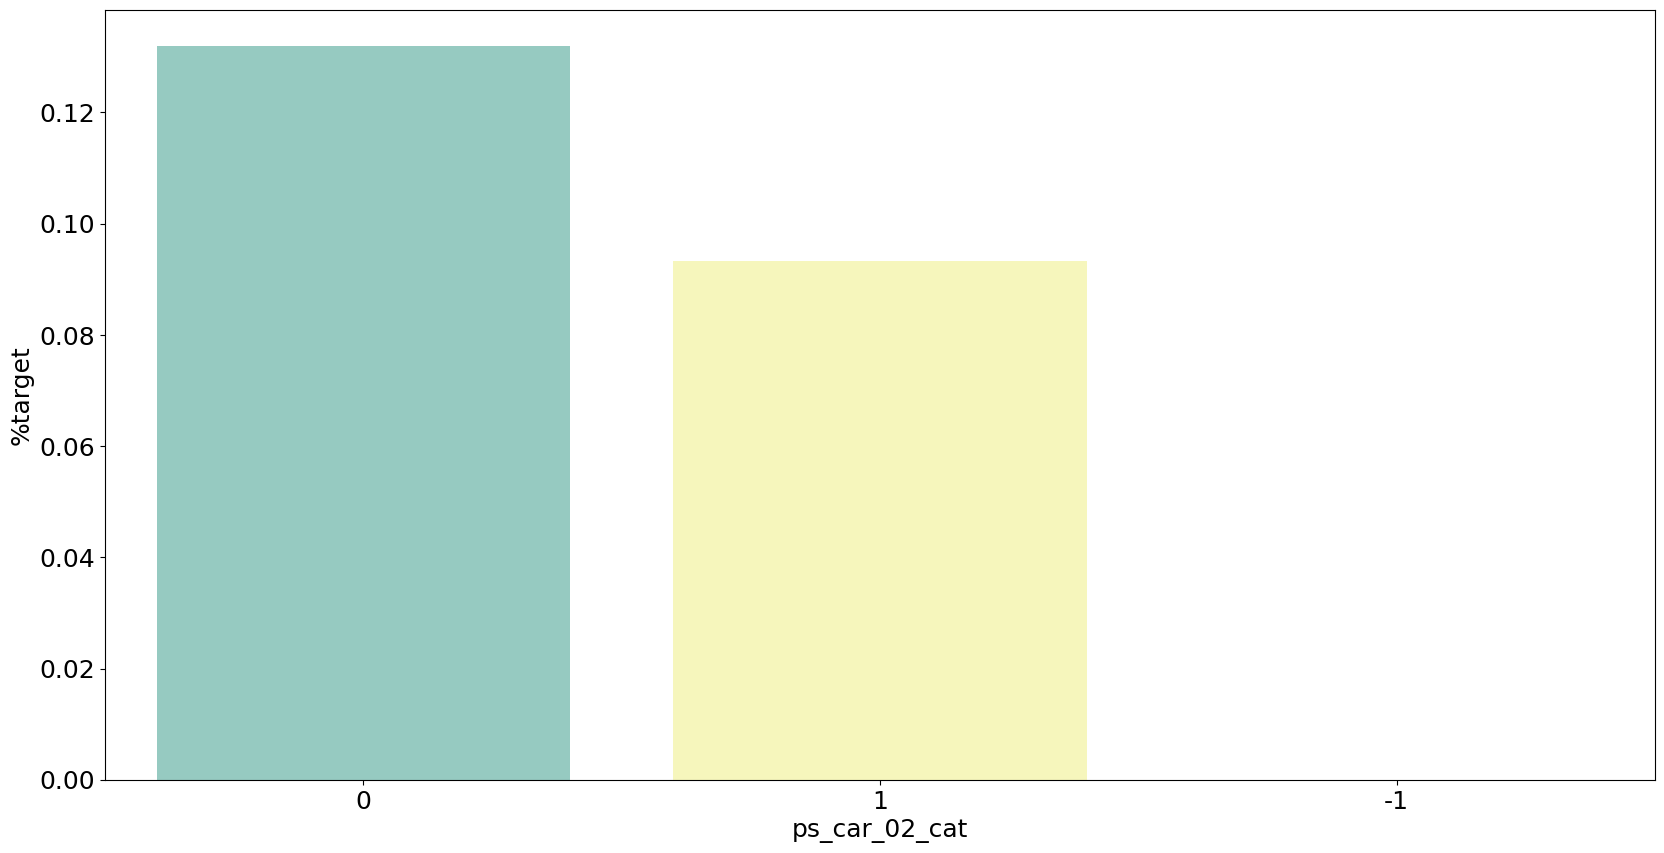

<Figure size 640x480 with 0 Axes>

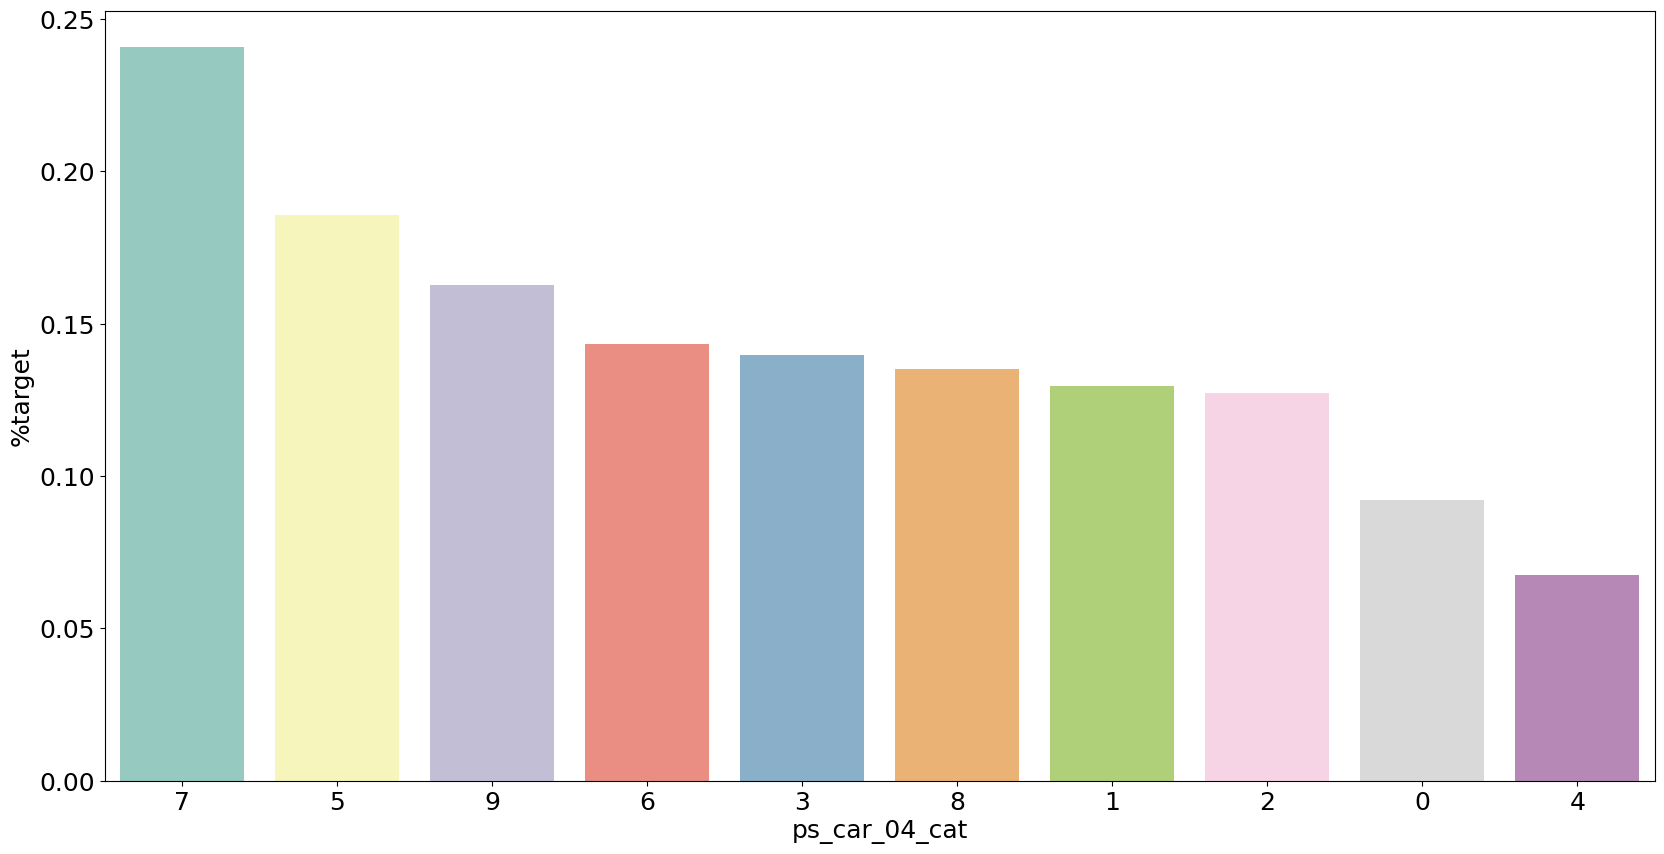

<Figure size 640x480 with 0 Axes>

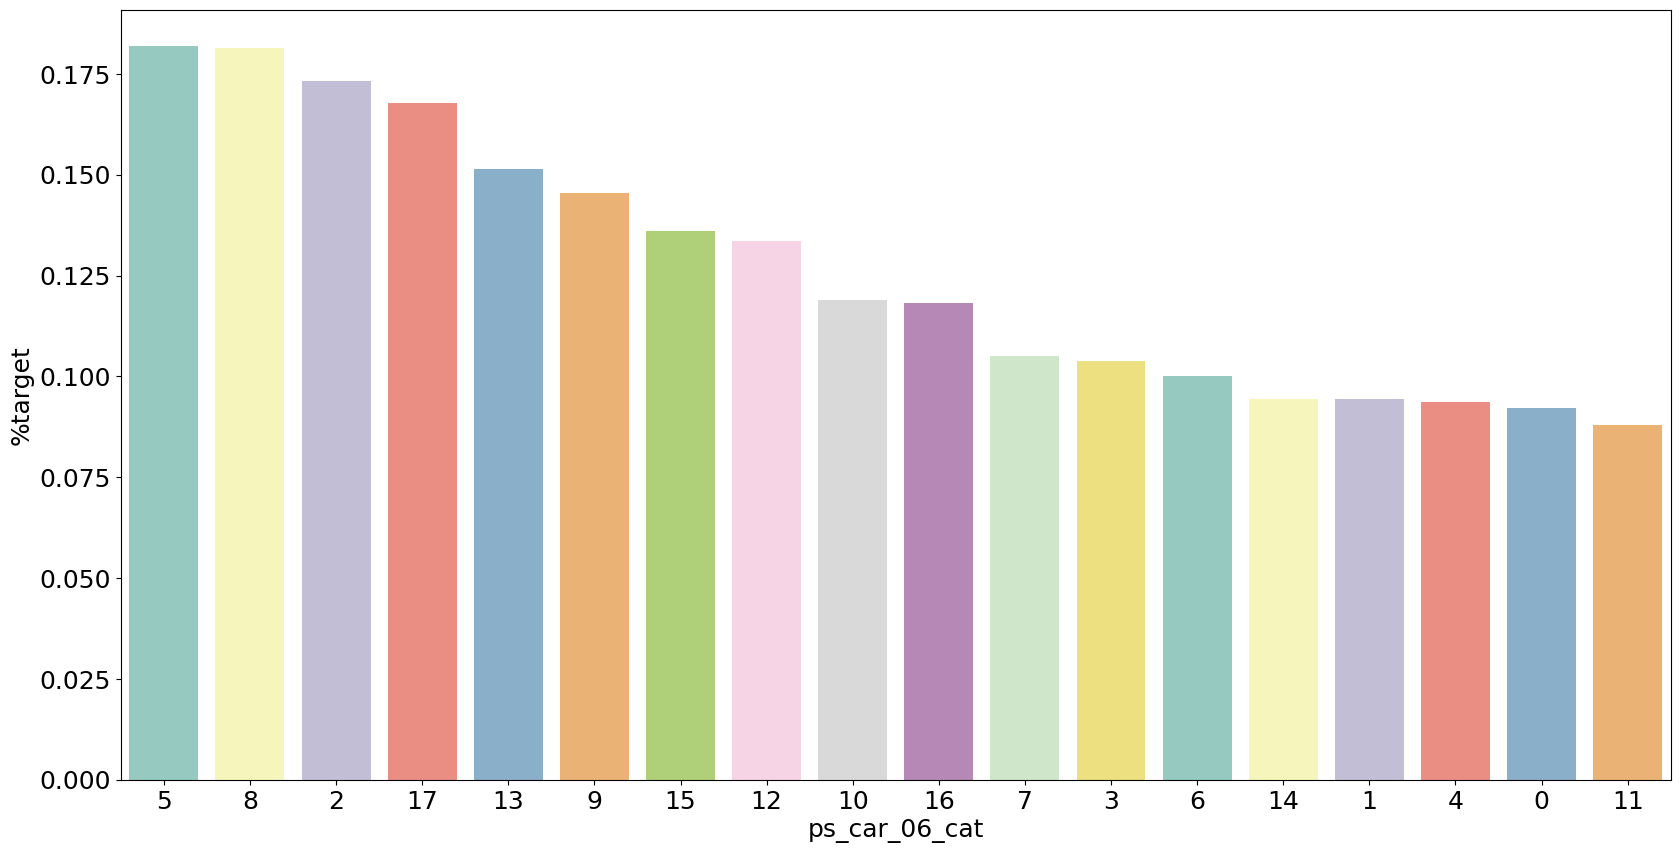

<Figure size 640x480 with 0 Axes>

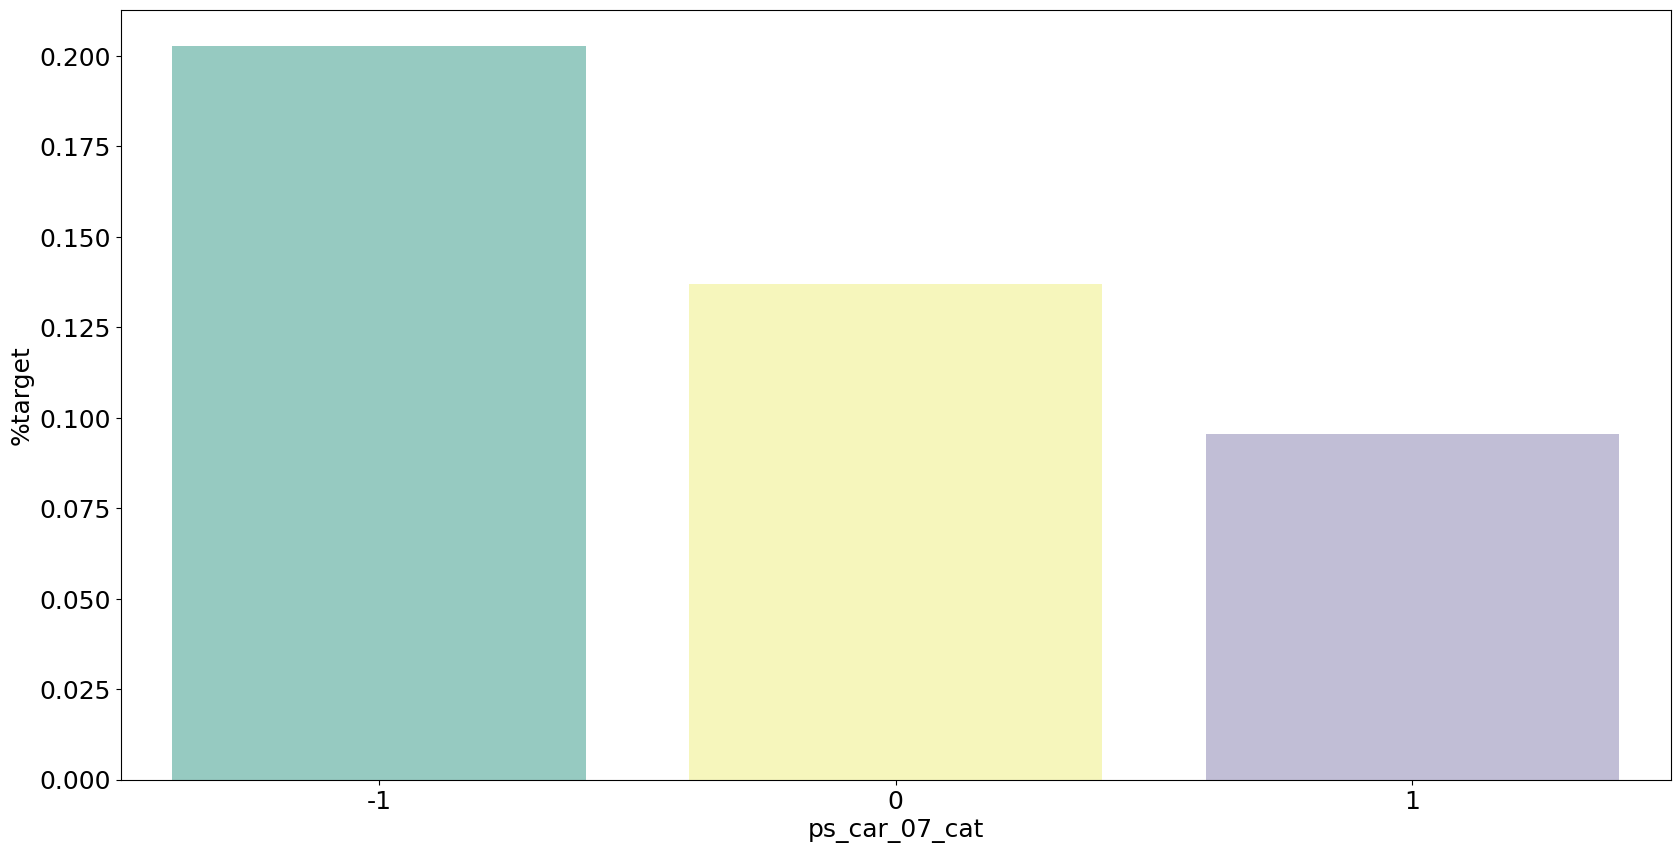

<Figure size 640x480 with 0 Axes>

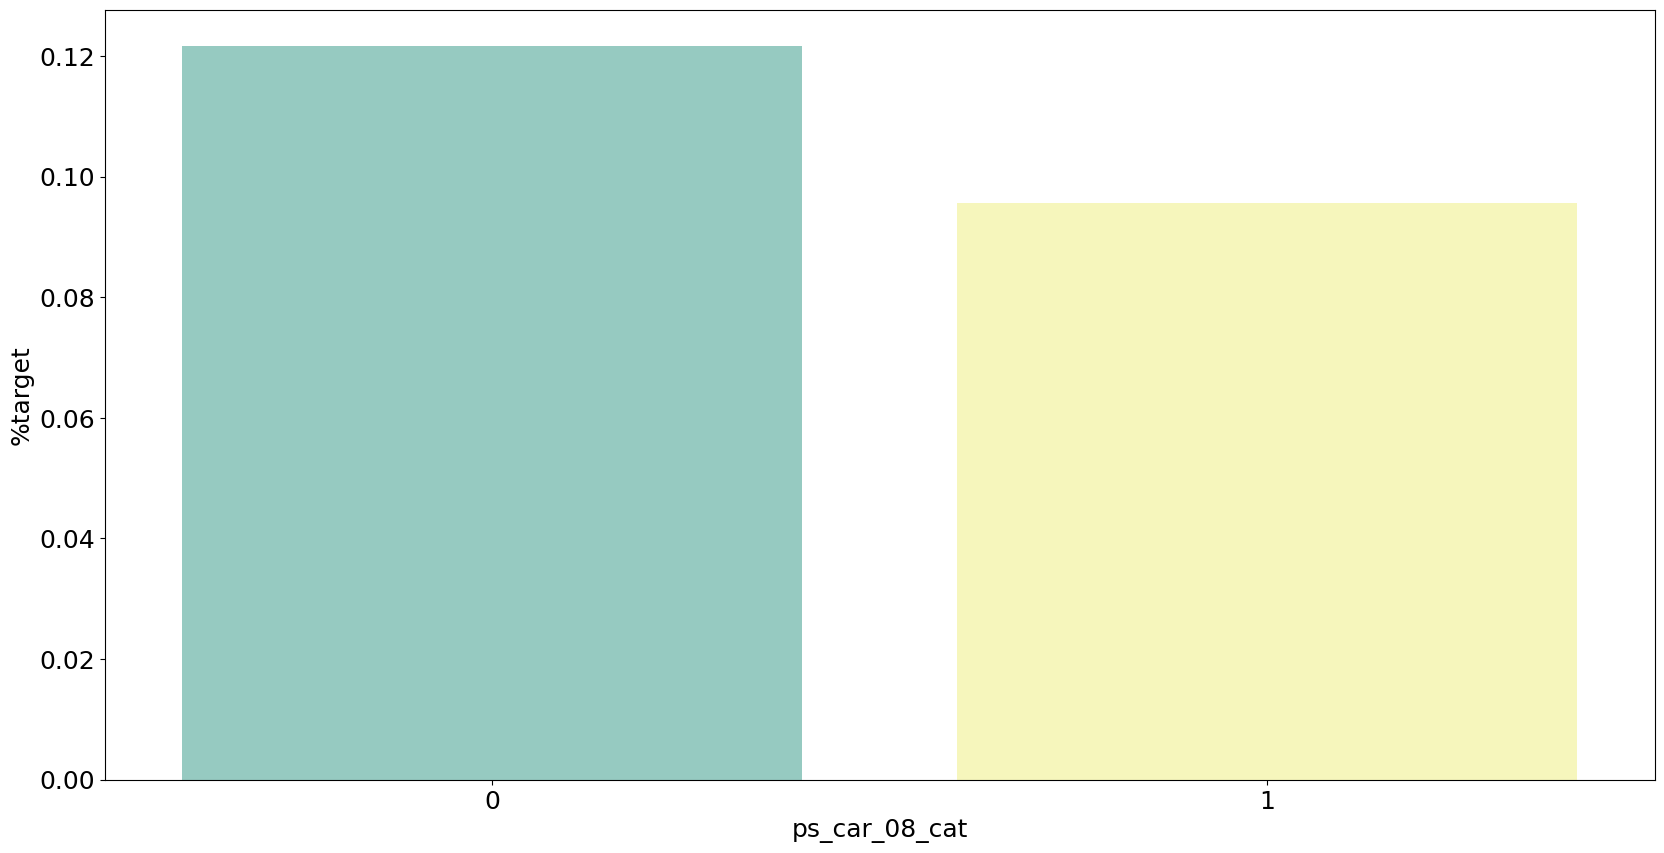

<Figure size 640x480 with 0 Axes>

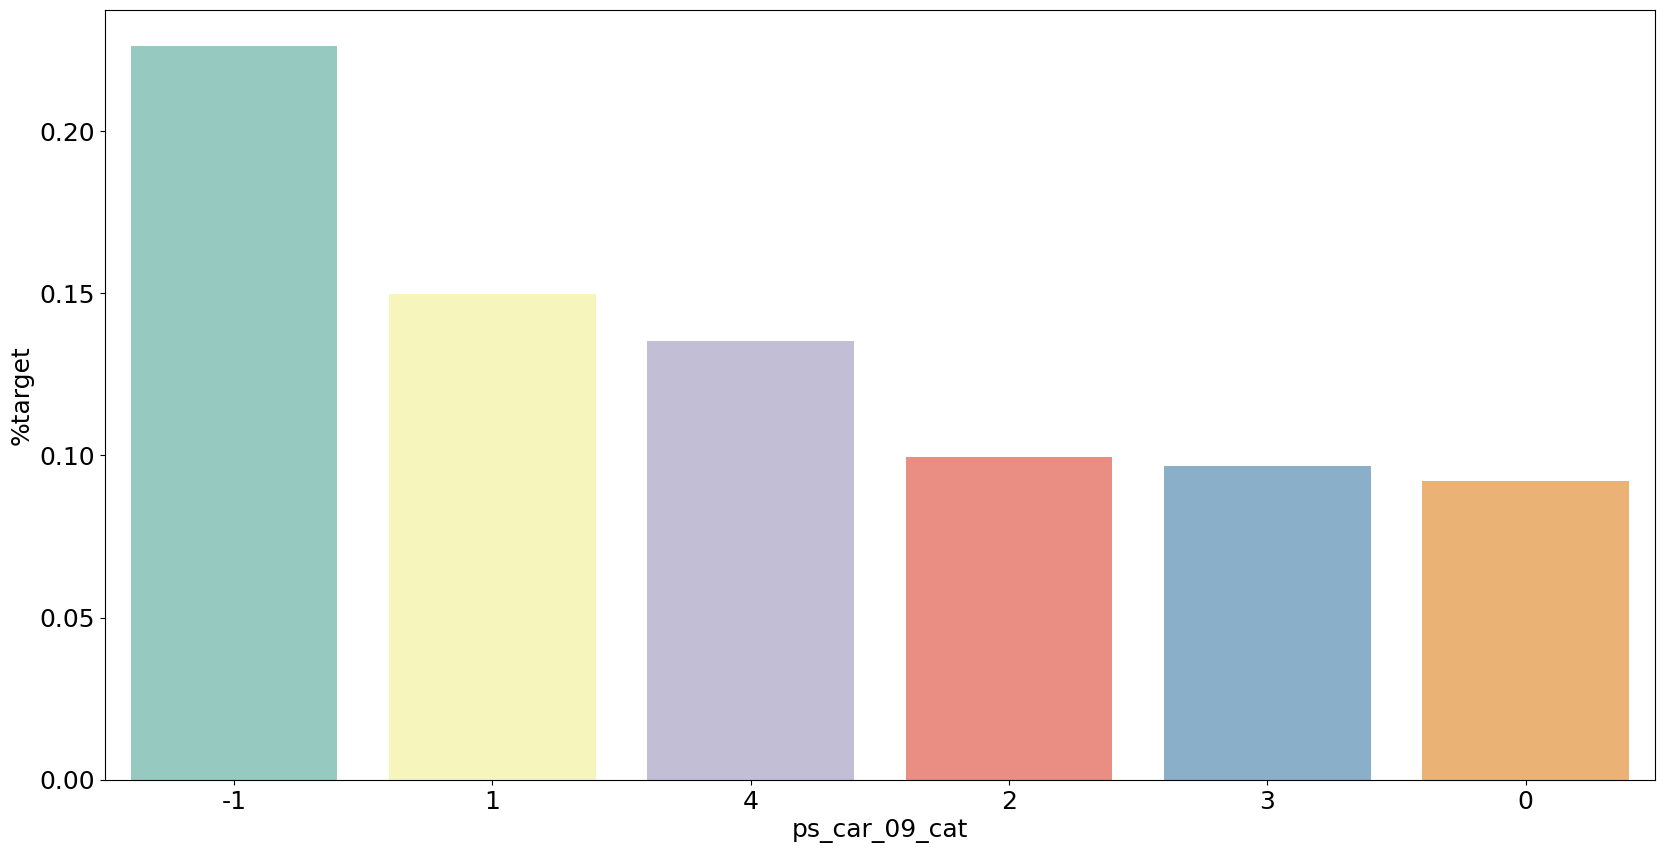

<Figure size 640x480 with 0 Axes>

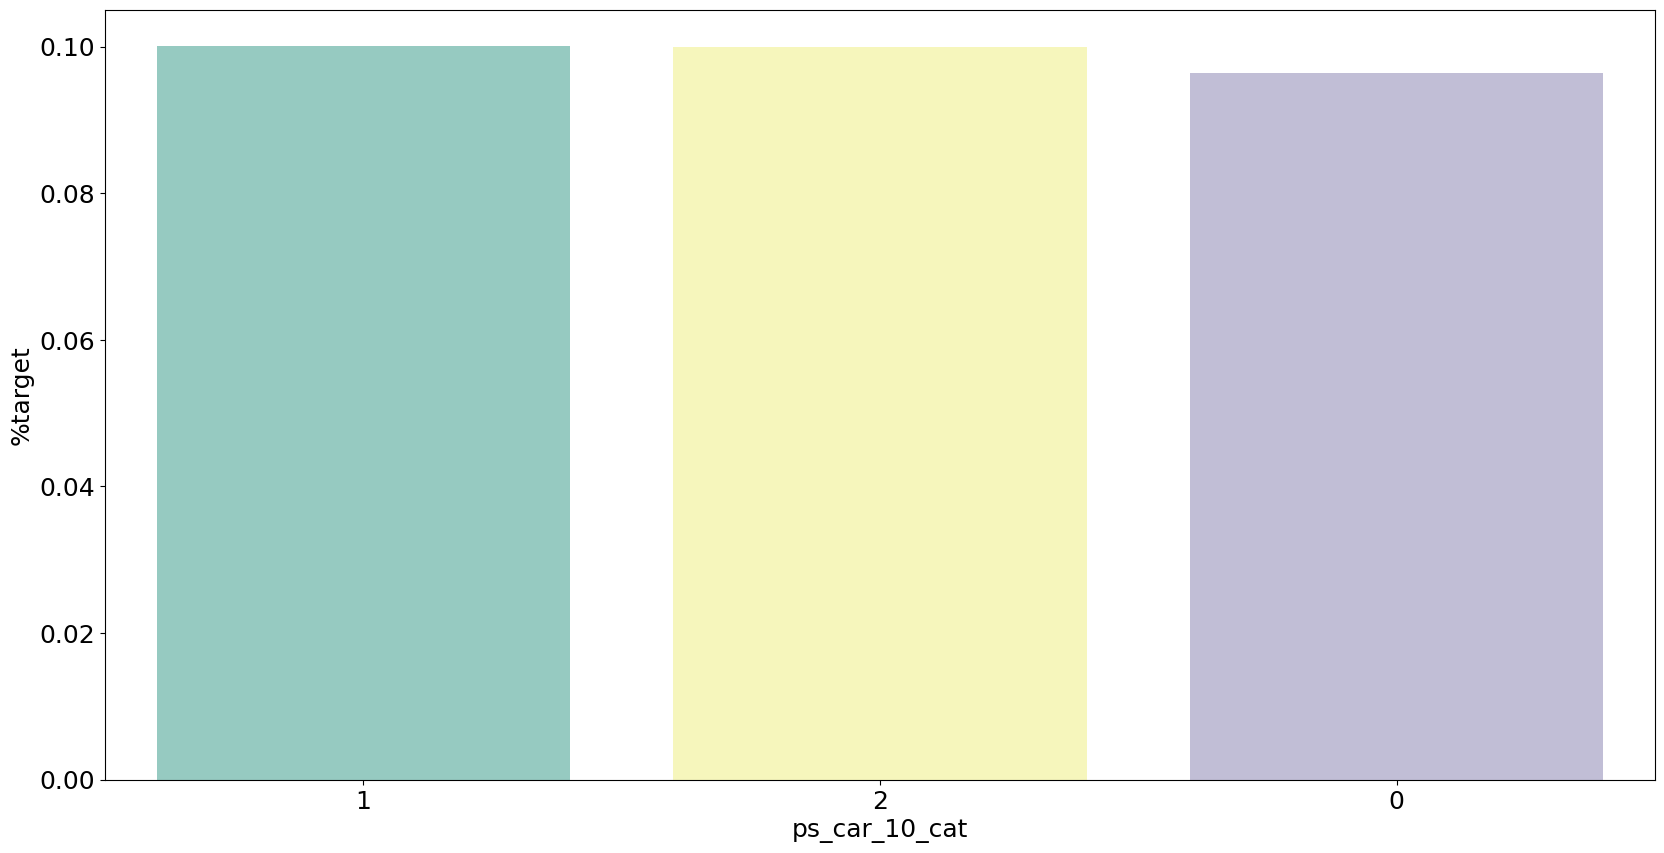

In [21]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize = (20,10))
    cat_perc = train[[f, 'target']].groupby([f], as_index=False).mean()
    cat_perc.sort_values(by='target' , ascending = False, inplace = True)

    sns.barplot(ax=ax, x=f, y='target', data = cat_perc, order = cat_perc[f], palette = 'Set3')

    plt.xlabel(f, fontsize=18)
    plt.ylabel('%target', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

#### interval variables

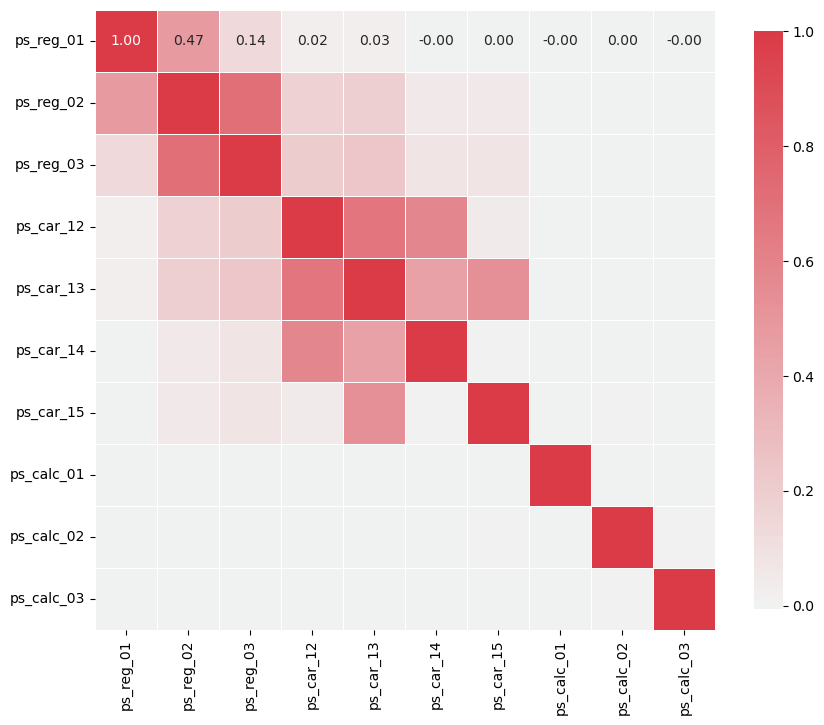

In [22]:
def corr_heatmap(v):
    correlations = train[v].corr()

    cmap = sns.diverging_palette(220, 10, as_cmap = True)

    fig, ax= plt.subplots(figsize = (10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={'shrink': .75})
    plt.show()

v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

상관성이 큰 변수가 많을 시 PCA를 적용해보는 것도 좋다..

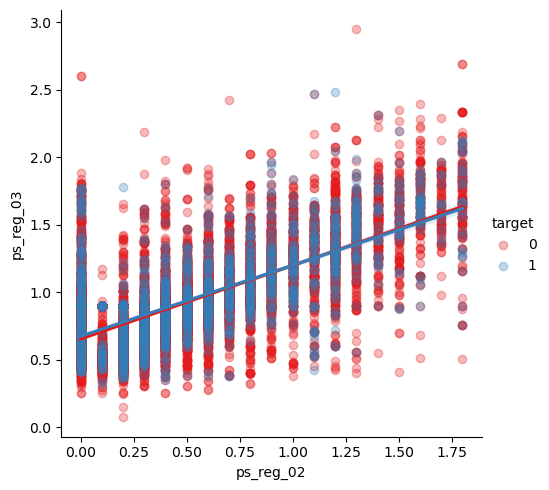

In [23]:
# 상관계수가 크게 나타난 변수 4쌍의 회귀선 시각화

s = train.sample(frac=0.1)  # 전체 데이터 중 10%로만 시각화하기

sns.lmplot(x = 'ps_reg_02', y = 'ps_reg_03', data=s, hue = 'target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

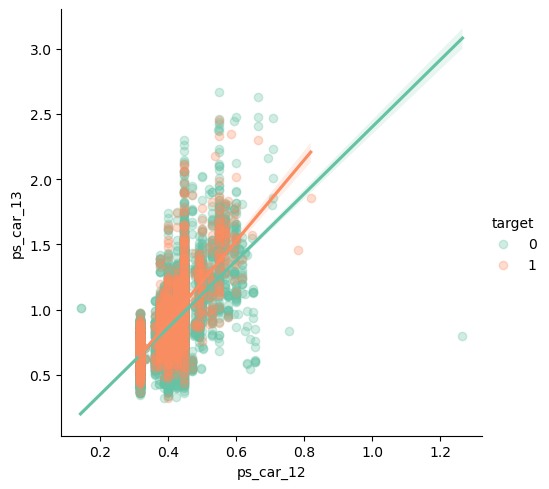

In [24]:
sns.lmplot(x = 'ps_car_12', y = 'ps_car_13', data=s, hue = 'target', palette='Set2', scatter_kws={'alpha':0.3})
plt.show()

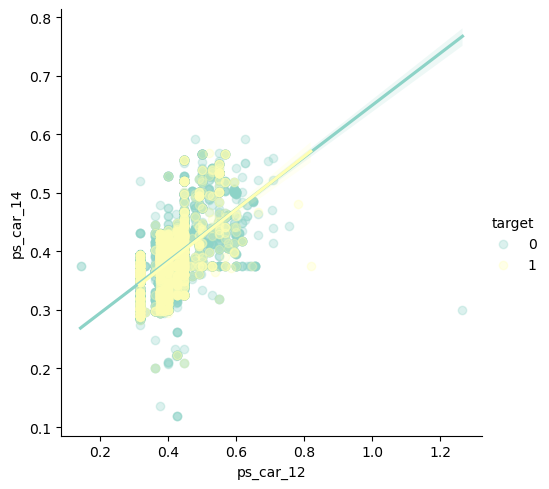

In [25]:
sns.lmplot(x = 'ps_car_12', y = 'ps_car_14', data=s, hue = 'target', palette='Set3', scatter_kws={'alpha':0.3})
plt.show()

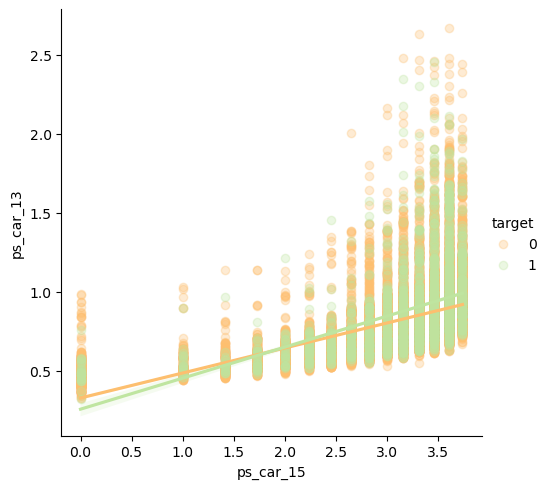

In [26]:
sns.lmplot(x = 'ps_car_15', y = 'ps_car_13', data=s, hue = 'target', palette='Spectral', scatter_kws={'alpha':0.3})
plt.show()

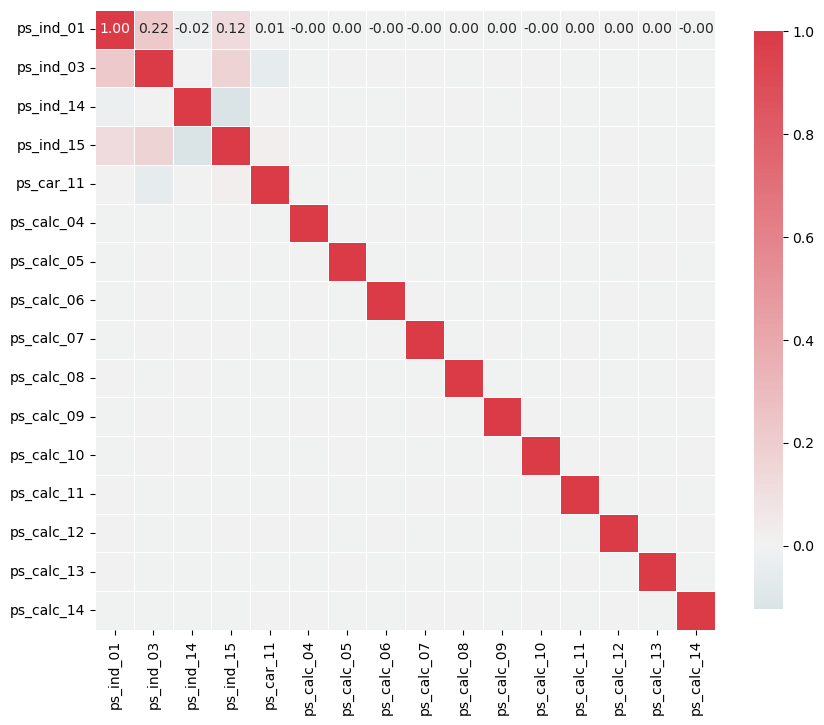

In [27]:
# 범주형 변수의 상관관계도 체크해보기

v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

### Feature Engineering

#### creating dummy variables

In [28]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
print('Before dummification we have', train.shape[1], 'variables in train')

train = pd.get_dummies(train, columns = v, drop_first = True)
print('After dummification we have', train.shape[1], 'variables in train')

Before dummification we have 57 variables in train
After dummification we have 213 variables in train


#### creating interaction variables

In [29]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names_out(v))
interactions.drop(v, axis=1, inplace=True)  # Remove the original columns
# Concat the interaction variables to the train data
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 213 variables in train
After creating interactions we have 268 variables in train


### Feature Selection

In [30]:
# variance가 작은 변수 삭제

selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

65 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_10_cat', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_14_1', 'ps_ind_14_2', 'ps_ind_14_3', 'ps_ind_14_4', 'ps_calc_05_6', 'ps_calc_06_2', 'ps_calc_06_3', 'ps_calc_07_7', 'ps_calc_07_8', 'ps_calc_07_9', 'ps_calc_08_3', 'ps_calc_08_4', 'ps_calc_08_5', 'ps_calc_09_6', 'ps_calc_09_7', 'ps_calc_10_1', 'ps_calc_10_2', 'ps_calc_10_16', 'ps_calc_10_17', 'ps_calc_10_18', 'ps_calc_10_19', 'ps_calc_10_20', 'ps_calc_10_21', 'ps_calc_10_22', 'ps_calc_10_23', 'ps_calc_10_24', 'ps_calc_11_12', 'ps_calc_11_13', 'ps_calc_11_14', 'ps_calc_11_15', 'ps_calc_11_16', 'ps_calc_11_17', 'ps_calc_11_18', 'ps_calc_12_6', 'ps_calc_12_7', 'ps_calc_12_8', 'ps_calc_12_9', 'ps_calc_12_10', 'ps_calc_13_8', 'ps_calc_13_9', 'ps_calc_13_10', 'ps_calc_13_11', 'ps_calc_13_12', 'ps_calc_13_13', 'ps_calc_14_1', 'ps_calc_14_15', 'ps_calc_14_16', 'ps_calc_14_17', 'ps_calc_14_18', 'ps_cal

In [33]:
# 랜덤포레스트 기반 변수 중요도

X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.019399
 2) ps_car_13                      0.016321
 3) ps_car_13^2                    0.016305
 4) ps_car_12 ps_car_13            0.016202
 5) ps_reg_03 ps_car_13            0.016185
 6) ps_car_13 ps_car_14            0.016080
 7) ps_reg_01 ps_car_13            0.015823
 8) ps_car_13 ps_car_15            0.015809
 9) ps_reg_03 ps_car_14            0.015387
10) ps_reg_03 ps_car_12            0.014717
11) ps_reg_03 ps_car_15            0.014328
12) ps_car_14 ps_car_15            0.014207
13) ps_car_13 ps_calc_01           0.014037
14) ps_car_13 ps_calc_02           0.013932
15) ps_car_13 ps_calc_03           0.013909
16) ps_reg_01 ps_reg_03            0.013884
17) ps_reg_02 ps_car_13            0.013811
18) ps_reg_01 ps_car_14            0.013642
19) ps_reg_03                      0.013607
20) ps_reg_03^2                    0.013583
21) ps_reg_03 ps_calc_03           0.013094
22) ps_reg_03 ps_calc_02           0.013049
23) ps_reg_03 ps_calc_01        

In [34]:
# SelectFromModel 모듈: 설정한 threshold와 선택한 classifier로 변수 선택 도와줌

sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 266


/Users/dayoungcho/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of features after selection: 133


In [35]:
train = train[selected_vars + ['target']]

### Feature Scaling

In [36]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.54103958,  1.17629506, -0.30376713, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [-0.54103958,  1.17629506,  0.42605446, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [-0.54103958,  1.17629506, -0.30376713, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.54103958,  1.17629506, -0.30376713, ..., -0.46445747,
         0.18545696,  0.27907892],
       [ 0.96226006, -0.84848813, -0.30376713, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [ 0.96226006, -0.84848813, -0.30376713, ...,  0.28148164,
        -0.11358706, -0.72653353]])